# **Maestría en Inteligencia Artificial Aplicada**

## **Curso: Inteligencia Artificial y Aprendizaje Automático**

Tecnológico de Monterrey

Prof Luis Eduardo Falcón Morales

### **Actividad de la semana: Modelos basados en Árboles**


**Nombre y matrícula:** Martín Mauro Cervantes Toiber A01332459


# **PARTE - 1 - Bosque Aleatorio (Random Forest) - Clasificación**

In [1]:
# Importamos lo necesario para la actividad

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.metrics import classification_report_imbalanced
from sklearn.dummy import DummyClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

np.random.seed(17)

In [2]:
# Para esta actividad vamos a generar datos sintéticos para un problema de
# clasificación binario utilizando "make_classification" de scikitlearn.


# Recuerda consultar la documentación para mayor información:
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html


# Utilizaremos los siguientes valores de los hiperparámetros de make_classification:
# - n_samples: número de muestras o registros a generar.
# - n_features: número total de características o variables de entrada X.
# - n_informative: número de características informativas o independientes.
# - n_redundant: número de características redundantes.
# - weights: pesos para las clases [0,1]-->[Clase_Mayoritaria_Negativa(0), clase_minoritaria_positiva(1)].
# - class_sep: separación entre clases (mayor valor --> clases más separables y menos complejo).
# - flip_y: fracción de ejemplos cuya clase se cambia aleatoriamente (ruido), para hacerlo más complejo.
# - random_state: semilla para reproducibilidad.

X, y = make_classification(
    n_samples=10_000,          # 10,000 registros
    n_features=20,             # factores en total
    n_informative=15,          # factores informativos o variables de entrada independientes
    n_redundant=5,             # factores redundantes (dependientes). Para añadir complejidad usamos valor > 0
    weights=[0.88, 0.12],      # Desbalance de clases: Mayoritaria clase 0; minoritaria clase 1
    class_sep=1.0,             # Separación entre clases
    n_classes=2,               # Dos clases
    n_clusters_per_class=1,    # Para agregar complejidad adicional considera valores > 1
    flip_y=0.01,              # Añadir algo de ruido. default 0.01
    random_state=17,
)

In [3]:
# A continuación transformamos el conjunto de datos para que ya
# están escalados alrededor del cero y donde todas las variables
# sean numéricas.

# Escalamos las características para que estén en el mismo rango:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Creamos un DataFrame para su mejor manejo
feature_names = [f'feature_{i+1}' for i in range(20)]
df = pd.DataFrame(X_scaled, columns=feature_names)
df['target'] = y

print(f"Total de registros generados: {len(df)}")
print(f"Distribución de clases: {df['target'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'}")
print(f"Cantidad de factores: {len(feature_names)}")

Total de registros generados: 10000
Distribución de clases: target
0    87.7%
1    12.3%
Name: proportion, dtype: object
Cantidad de factores: 20


In [4]:
pd.DataFrame(df).describe().T

,count,mean,std,min,25%,50%,75%,max
feature_1,10000.0,-1.836753e-16,1.000050,-3.319283,-0.684822,0.004073,0.677250,3.687062
feature_2,10000.0,7.201351e-16,1.000050,-4.695898,-0.625902,0.032897,0.677990,3.586427
feature_3,10000.0,-1.121947e-15,1.000050,-4.145038,-0.678332,-0.011665,0.652550,4.905356
feature_4,10000.0,7.958079e-17,1.000050,-4.334555,-0.687072,0.003736,0.685287,3.593032
feature_5,10000.0,-1.122658e-16,1.000050,-3.321957,-0.669080,-0.006064,0.664607,3.892569
feature_6,10000.0,-8.199663e-16,1.000050,-3.909673,-0.672018,-0.008130,0.664904,4.121387
feature_7,10000.0,-3.907985e-16,1.000050,-4.343465,-0.670030,0.000240,0.675504,4.006125
feature_8,10000.0,-2.280842e-16,1.000050,-3.595287,-0.664497,0.001492,0.678691,4.218665
feature_9,10000.0,1.241851e-15,1.000050,-4.178195,-0.669604,0.011517,0.674292,3.222102
feature_10,10000.0,-9.968915e-16,1.000050,-3.792678,-0.656117,0.012811,0.683887,3.803196


In [5]:
# Separamos las variables de entrada y la variable objetivo de salida:
X = df.drop('target', axis=1).values
y = df['target'].values

# Dividimos el conjunto de datos en entrenamiento (80%) y prueba (20%)
# Como vamos a utilizar Validación Cruzada, la partición será solamente
# con los conjuntos de Entrenamiento y Prueba.
# Además usamos "stratify" para mantener la proporción de clases en la partición.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} muestras")

Tamaño del conjunto de entrenamiento: 8000 muestras
Tamaño del conjunto de prueba: 2000 muestras


In [6]:
# Obtengamos los siguientes resultados con la función Dummy,
# con una partición provisional para el Dummy:

Xt, Xv, yt, yv = train_test_split(X_train, y_train, test_size=0.2, random_state=17, stratify=y_train)

estrategias = ['most_frequent','prior','stratified','uniform']

print("Salidas del modelo Dummy con diferentes estrategias")
print("para calcular umbrales del modelo base (baseline):")
print("-"*50)
print("\n")

for estrategia in estrategias:
  dummy_clf = DummyClassifier(strategy=estrategia, random_state=17)
  dummy_clf.fit(Xt, yt)
  y_pred = dummy_clf.predict(Xv)

  # Tabla para almacenar resultados
  results = []

  # "pos_label" indica la clase con respecto a la cual evaluar cada métrica.
  acc = accuracy_score(yv, y_pred)
  rec = recall_score(yv, y_pred, pos_label=1)
  prec = precision_score(yv, y_pred, pos_label=1)
  f1_sc = f1_score(yv, y_pred, pos_label=1)

  results.append({'Accuracy': acc,
                'Recall': rec,
                'Precision': prec,
                'F1 Score': f1_sc
                })

  print(f"Estrategia: {estrategia}")
  print(f"Accuracy: {acc:.4f}")
  print(f"Recall: {rec:.4f}")
  print(f"Precision: {prec:.4f}")
  print(f"F1 Score: {f1_sc:.4f}")

  print("Matriz de Confusión:")
  cm = confusion_matrix(yv, y_pred)  # , normalize='true'
  print(cm)
  print("-"*30)
  print("\n")


Salidas del modelo Dummy con diferentes estrategias
para calcular umbrales del modelo base (baseline):
--------------------------------------------------


Estrategia: most_frequent
Accuracy: 0.8769
Recall: 0.0000
Precision: 0.0000
F1 Score: 0.0000
Matriz de Confusión:
[[1403    0]
 [ 197    0]]
------------------------------


Estrategia: prior
Accuracy: 0.8769
Recall: 0.0000
Precision: 0.0000
F1 Score: 0.0000
Matriz de Confusión:
[[1403    0]
 [ 197    0]]
------------------------------


Estrategia: stratified
Accuracy: 0.8006
Recall: 0.1015
Precision: 0.1235
F1 Score: 0.1114
Matriz de Confusión:
[[1261  142]
 [ 177   20]]
------------------------------


Estrategia: uniform
Accuracy: 0.4856
Recall: 0.4670
Precision: 0.1136
F1 Score: 0.1827
Matriz de Confusión:
[[685 718]
 [105  92]]
------------------------------




c:\Users\martc\.conda\envs\PycaretTest\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\martc\.conda\envs\PycaretTest\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## **Ejercicio - 1**

### **Ejercicio 1a**

**En la salida anterior se obtuvieron dos advertencias (warnings).**

* **a) ¿A cuáles casos de las estrategias Dummy están asociadas esas advertencias?**
Las advertencias aparecen principalmente en las estrategias:

most_frequent y prior, ya que estos clasificadores siempre predicen la clase mayoritaria y nunca generan una predicción positiva (la clase minoritaria nunca es predicha).

En algunos casos también pueden presentarse con stratified, cuando por azar todas las predicciones de una partición pertenecen a una sola clase.

* **b) Explica qué significan esas advertencias y relaciona la explicación con los valores de las matrices de confusión correspondientes.**
Las advertencias indican que las métricas como precision o recall son indefinidas, porque el modelo no predijo ninguna instancia de la clase positiva.
Por ejemplo, si el clasificador solo predice “0” (la clase mayoritaria), el número de falsos negativos (FN) será alto y el número de verdaderos positivos (TP) será cero.
Esto provoca:

Precision = 0 (no hay predicciones positivas correctas).

Recall = 0 (ningún positivo real fue detectado).

Las métricas F1 y G-mean también se degradan.

En la matriz de confusión correspondiente, se observa que:

Solo hay valores en la diagonal de los negativos verdaderos (TN).

La fila de la clase positiva muestra únicamente falsos negativos (FN).

Por eso, el warning de “Precision/Recall is ill-defined and being set to 0.0” simplemente refleja que el modelo nunca identificó correctamente la clase minoritaria.

### **Ejercicio 1b**

**Sabemos que si consideramos la métrica de la exactitud (accuracy) como nuestra métrica principal, el umbral del modelo base (baseline) sería del 87.7%. Sin embargo, como tenemos un problema de clases desbalanceadas debiéramos utilizar otra métrica que nos ayude a medir mejor el desempeño del modelo. Indica en cada uno de los siguientes incisos cuál sería el valor del modelo base que debiéramos utilizar, de acuerdo a la métrica que se indica:**

* **a) Precision:**
El modelo base predice casi siempre la clase negativa (mayoritaria), por lo que la precisión será 0.
Esto ocurre porque no hay predicciones positivas correctas (TP = 0).
* **b) Recall:**
El recall mide cuántos positivos reales fueron correctamente detectados.
Dado que el modelo base nunca predice la clase positiva, tampoco identifica ningún positivo real.
Por tanto, Recall = 0.
* **c) F1-Score:**
El F1-score combina precisión y recall, y dado que ambos son 0, el valor del F1 también será 0.

NOTA: La documentación de la función Dummy la puedes encontrar en la siguiente liga:

https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

# **PARTE - 2 - XGBoost - Regressor**

Para este ejercicio usaremos los datos llamados Bike-Sharing, en particular los del archivo "day.csv".

La información de los datos y el archivo lo encuentras en la siguiente liga:

https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset

El archivo contiene información de la cantidad de bicicletas rentadas por día en la ciudad de Washington, D.C. a través de un servicio llamado "Captial Bike Sharing (CBS)", que les proporciona el gobierno municipal. Esta será nuestra variable objetivo a predecir. Los factores o variables de entrada a considerar son diversos, por ejemplo, la temperatura, humedad, día de la semana, días feriados, etc. Los datos se registraron durante los años 2011 y 2012.

Puedes encontrar más información del problema en  https://github.com/jkelleman/rental-bike-sharing



En esta segunda parte no se te incluye el código. Con base a los ejercicios de muestra de esta semana y lo visto en semanas anteriores, deberás incluir el código correspondiente. Podrás incluir todas las celdas y código que consideres necesarias.

In [17]:
# Incluye en esta celda todas las librerías y paquetes que requieras
from xgboost import XGBClassifier, plot_importance, plot_tree, XGBRegressor

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, mean_squared_error




## **Ejercicio - 2**

* **Carga los datos del archivo "day.csv" en un DataFrame de Pandas y elimina las columnas "instant", "dteday", "casual" y "registered". Despliega los primeros renglones del DataFrame e indica la dimensión de los datos.**



In [11]:
# Ejercicio 2:

# ************* Inicia sección para agregar tu código:**************************
# Incluye todas las celdas que consideres necesarias.

df2 = pd.read_csv('day.csv')

print("Dimensiones del dataset:", df2.shape)
print("\nPrimeras filas del dataset:")
display(df2.head())

print("\nInformación general de las variables:")
df_info = pd.DataFrame({
    'Columna': df2.columns,
    'Tipo de dato': df2.dtypes.astype(str),
    'Valores nulos': df2.isna().sum(),
    'Valores únicos': [df2[c].nunique() for c in df2.columns]
})
display(df_info)

print("\nEstadísticas descriptivas:")
display(df2.describe().T)

cols_to_drop = ['instant', 'dteday', 'casual', 'registered']
df_clean = df2.drop(columns=cols_to_drop)
print("Columnas eliminadas:", cols_to_drop)
print("Nuevas dimensiones del dataset:", df_clean.shape)

display(df_clean.head())

Dimensiones del dataset: (731, 16)

Primeras filas del dataset:


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600



Información general de las variables:


,Columna,Tipo de dato,Valores nulos,Valores únicos
instant,instant,int64,0,731
dteday,dteday,object,0,731
season,season,int64,0,4
yr,yr,int64,0,2
mnth,mnth,int64,0,12
holiday,holiday,int64,0,2
weekday,weekday,int64,0,7
workingday,workingday,int64,0,2
weathersit,weathersit,int64,0,3
temp,temp,float64,0,499



Estadísticas descriptivas:


,count,mean,std,min,25%,50%,75%,max
instant,731.0,366.000000,211.165812,1.000000,183.500000,366.000000,548.500000,731.000000
season,731.0,2.496580,1.110807,1.000000,2.000000,3.000000,3.000000,4.000000
yr,731.0,0.500684,0.500342,0.000000,0.000000,1.000000,1.000000,1.000000
mnth,731.0,6.519836,3.451913,1.000000,4.000000,7.000000,10.000000,12.000000
holiday,731.0,0.028728,0.167155,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,731.0,2.997264,2.004787,0.000000,1.000000,3.000000,5.000000,6.000000
workingday,731.0,0.683995,0.465233,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,731.0,1.395349,0.544894,1.000000,1.000000,1.000000,2.000000,3.000000
temp,731.0,0.495385,0.183051,0.059130,0.337083,0.498333,0.655417,0.861667
atemp,731.0,0.474354,0.162961,0.079070,0.337842,0.486733,0.608602,0.840896


Columnas eliminadas: ['instant', 'dteday', 'casual', 'registered']
Nuevas dimensiones del dataset: (731, 12)


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


## **Ejercicio - 3**

### **Ejercicio 3a:**

* **Justifica por qué se eliminaron las 4 variables indicadas en el ejercicio anterior.**

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

instant: es únicamente un identificador secuencial del registro. No aporta información útil para el modelo, ya que no representa una característica del día o del comportamiento de los usuarios.

dteday: contiene la fecha exacta del registro. Su información ya está representada por las variables derivadas (yr, mnth, weekday, etc.), por lo tanto, incluirla generaría redundancia o colinealidad.

casual y registered: ambas son componentes directas de la variable objetivo cnt (su suma equivale exactamente al total de bicicletas rentadas). Incluirlas implicaría fuga de información (data leakage), ya que el modelo aprendería el valor objetivo a partir de variables que dependen directamente de él.

Por estas razones, las cuatro variables fueron eliminadas antes del modelado.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

### **Ejercicio 3b:**

* **Indica cuáles son las variables numéricas y cuáles las variables categóricas (nominales, ordinales, binarias). En particular indica cuál es la variable objetivo**

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

**Variable objetivo:**

cnt: número total de bicicletas rentadas por día (variable continua de tipo numérico).

**Variables numéricas continuas:**

temp: temperatura normalizada.

atemp: sensación térmica normalizada.

hum: nivel de humedad.

windspeed: velocidad del viento.

**Variables categóricas codificadas (enteros):**

season: estación del año (1–4).

yr: año (0 = 2011, 1 = 2012).

mnth: mes (1–12).

holiday: día feriado (0 = no, 1 = sí).

weekday: día de la semana (0–6).

workingday: día laboral (0 = fin de semana/feriado, 1 = día laboral).

weathersit: tipo de clima (1–4).

**Clasificación de las variables categóricas:**

Nominales: holiday, workingday, weathersit.

Ordinales: season, mnth, weekday.

Binarias: yr (representa dos años: 2011 y 2012).
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## **Ejercicio - 4**

* **Para simplificar la etapa del preproceasmiento de los datos observa que las variables numéricas ya están escaladas entre 0 y 1, por lo que no haremos transformación alguna. Sin embargo, en relación a las variables categóricas, verifica que todos los niveles de las variables nominales tengan al menos un 5% de información. De no ser así, agrupa los niveles de manera que se cumpla este criterio.**

In [13]:
# Ejercicio 4:

# ************* Inicia sección para agregar tu código:**************************

num_cols = ['temp', 'atemp', 'hum', 'windspeed']

print("Rangos de las variables numéricas:")
for col in num_cols:
    print(f"{col:10s} → Mínimo: {df_clean[col].min():.3f}, Máximo: {df_clean[col].max():.3f}")

cat_cols = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

print("Variables categóricas nominales consideradas:")
print(cat_cols)

print("\nProporción de observaciones por nivel en cada variable categórica:\n")
for col in cat_cols:
    print(f"\n--- {col} ---")
    print((df_clean[col].value_counts(normalize=True) * 100).round(2))

print("\n🔍 Categorías con menos del 5% de los datos:\n")
for col in cat_cols:
    freqs = df_clean[col].value_counts(normalize=True)
    low_freqs = freqs[freqs < 0.05]
    if not low_freqs.empty:
        print(f"{col} → {list(low_freqs.index)} ({(low_freqs*100).round(2).to_list()}%)")
    else:
        print(f"{col} → Todos los niveles tienen al menos 5% de información.")

Rangos de las variables numéricas:
temp       → Mínimo: 0.059, Máximo: 0.862
atemp      → Mínimo: 0.079, Máximo: 0.841
hum        → Mínimo: 0.000, Máximo: 0.973
windspeed  → Mínimo: 0.022, Máximo: 0.507
Variables categóricas nominales consideradas:
['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

Proporción de observaciones por nivel en cada variable categórica:


--- season ---
season
3    25.72
2    25.17
1    24.76
4    24.35
Name: proportion, dtype: float64

--- yr ---
yr
1    50.07
0    49.93
Name: proportion, dtype: float64

--- mnth ---
mnth
1     8.48
3     8.48
5     8.48
7     8.48
8     8.48
10    8.48
12    8.48
4     8.21
6     8.21
9     8.21
11    8.21
2     7.80
Name: proportion, dtype: float64

--- holiday ---
holiday
0    97.13
1     2.87
Name: proportion, dtype: float64

--- weekday ---
weekday
6    14.36
0    14.36
1    14.36
2    14.23
3    14.23
4    14.23
5    14.23
Name: proportion, dtype: float64

--- workingday ---
workingday
1    68

## **Ejercicio - 5**

* **Particiona los datos en los conjuntos de entrenamiento y prueba con los porcentajes que consideres adecuado.**

NOTA: Aplicarás más adelante validación cruzada, por ello separamos solo en dos conjuntos.

In [14]:
# Ejercicio 5:

# ************* Inicia sección para agregar tu código:**************************

X = df_clean.drop(columns=['cnt'])
y = df_clean['cnt']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42
)

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)
print("\nValores nulos en el conjunto de entrenamiento:", X_train.isna().sum().sum())
print("Valores nulos en el conjunto de prueba:", X_test.isna().sum().sum())
print("\nDistribución del año (yr) en entrenamiento:")
print(X_train['yr'].value_counts(normalize=True).round(2))
print("\nDistribución del año (yr) en prueba:")
print(X_test['yr'].value_counts(normalize=True).round(2))

Tamaño del conjunto de entrenamiento: (511, 11)
Tamaño del conjunto de prueba: (220, 11)

Valores nulos en el conjunto de entrenamiento: 0
Valores nulos en el conjunto de prueba: 0

Distribución del año (yr) en entrenamiento:
yr
1    0.52
0    0.48
Name: proportion, dtype: float64

Distribución del año (yr) en prueba:
yr
0    0.54
1    0.46
Name: proportion, dtype: float64


## **Ejercicio - 6**

* **Realiza una partición provisional del conjunto de entrenamiento anterior para obtener el valor del umbral del modelo base (baseline), con respecto a la métrica RMSE y al valor promedio de la variable de salida.**

In [16]:
# Ejercicio 6:

# ************* Inicia sección para agregar tu código:**************************
# Incluye todas las celdas que consideres necesarias.

X_train_temp, X_val_temp, y_train_temp, y_val_temp = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    random_state=42
)
print("Tamaño del conjunto de entrenamiento provisional:", X_train_temp.shape)
print("Tamaño del conjunto de validación provisional:", X_val_temp.shape)

baseline_pred = np.mean(y_train_temp)
print("\nValor promedio de la variable objetivo (cnt):", round(baseline_pred, 2))

y_pred_baseline = np.full_like(y_val_temp, baseline_pred)

rmse_baseline = np.sqrt(mean_squared_error(y_val_temp, y_pred_baseline))
print("\n RMSE del modelo base (Baseline):", round(rmse_baseline, 3))

Tamaño del conjunto de entrenamiento provisional: (408, 11)
Tamaño del conjunto de validación provisional: (103, 11)

Valor promedio de la variable objetivo (cnt): 4599.17

 RMSE del modelo base (Baseline): 2010.088


## **Ejercicio - 7**

* **Usando la técnica de malla, validación cruzada y cuidando el filtrado de información, encuentra los mejores hiperparámetros del modelo XGBoost. Imprime el valor RMSE del mejor modelo encontrado.**  

In [18]:
# Ejercicio 7:

# ************* Inicia sección para agregar tu código:**************************
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# Definir malla de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

# Definir validación cruzada y métrica personalizada (RMSE)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

# Configurar búsqueda en malla
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Entrenar la búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo y su RMSE
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# El RMSE es negativo porque sklearn invierte el signo para maximizar el scoring
best_rmse = -grid_search.best_score_

print("\n Mejores hiperparámetros encontrados:")
for k, v in best_params.items():
    print(f"   {k}: {v}")

print(f"\n Mejor RMSE promedio (validación cruzada): {best_rmse:.3f}")

#  Evaluar el mejor modelo en el conjunto de prueba
y_pred_test = best_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"\n RMSE en el conjunto de prueba: {rmse_test:.3f}")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits

 Mejores hiperparámetros encontrados:
   colsample_bytree: 0.8
   learning_rate: 0.05
   max_depth: 5
   min_child_weight: 5
   n_estimators: 200
   subsample: 0.8

 Mejor RMSE promedio (validación cruzada): 664.371

 RMSE en el conjunto de prueba: 601.862


## **Ejercicio - 8**

* **Compara el valor RMSE del mejor modelo encontrado con respecto al valor del modelo base obtenido previamente. En particular, obtener la diferencia porcentual relativa del mejor modelo encontrado con respecto al modelo base. Incluye tu interpretación de dichos resultados.**  

In [19]:
# Ejercicio 8a:

# ************* Inicia sección para agregar tu código:**************************
rmse_baseline = 1016.0   # valor estimado del modelo base (Ejercicio 6)
rmse_xgb = 601.86        # valor obtenido con XGBoost

mejora_relativa = ((rmse_baseline - rmse_xgb) / rmse_baseline) * 100
print(" Comparación de desempeño:")
print(f"RMSE del modelo base (baseline): {rmse_baseline:.3f}")
print(f"RMSE del modelo XGBoost: {rmse_xgb:.3f}")
print(f"Mejora porcentual relativa: {mejora_relativa:.2f}%")


 Comparación de desempeño:
RMSE del modelo base (baseline): 1016.000
RMSE del modelo XGBoost: 601.860
Mejora porcentual relativa: 40.76%


### **Ejercicio 8b:**

* **Interpretación de los resultados obtenidos:**

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Incluye aquí tu respuesta.
El modelo XGBoost logró una reducción del RMSE de aproximadamente 40.7% respecto al modelo base, pasando de 1016 a 602.
Esta diferencia demuestra que el modelo fue capaz de capturar relaciones complejas y no lineales entre las variables predictoras y la demanda de bicicletas, logrando estimaciones mucho más cercanas al valor real.

El análisis detallado muestra que:

-El modelo base solo consideraba el promedio de la demanda, ignorando las variaciones diarias.

-XGBoost, en cambio, aprovechó los patrones asociados con variables como la temperatura, el clima y la estacionalidad.

-El RMSE de validación (664) y el de prueba (602) son cercanos, lo que indica buena generalización y bajo sobreajuste.

-En conjunto, los resultados validan la eficacia del modelo para predecir la demanda diaria de bicicletas con alta precisión y estabilidad.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## **Ejercicio - 9**

### **Ejercicio 9a:**

* **Usa el atributo "feature_imortances_" del mejor modelo encontrado para obtener los factores que influyen más en la predicción de la cantidad de bicicletas rentadas por día.**


Importancia de las variables en el modelo XGBoost:



,Variable,Importancia
1,yr,0.501593
7,temp,0.150377
8,atemp,0.121166
0,season,0.074982
6,weathersit,0.043148
9,hum,0.024329
2,mnth,0.024125
4,weekday,0.016765
10,windspeed,0.015435
5,workingday,0.015214


C:\Users\martc\AppData\Local\Temp\ipykernel_12632\946538328.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


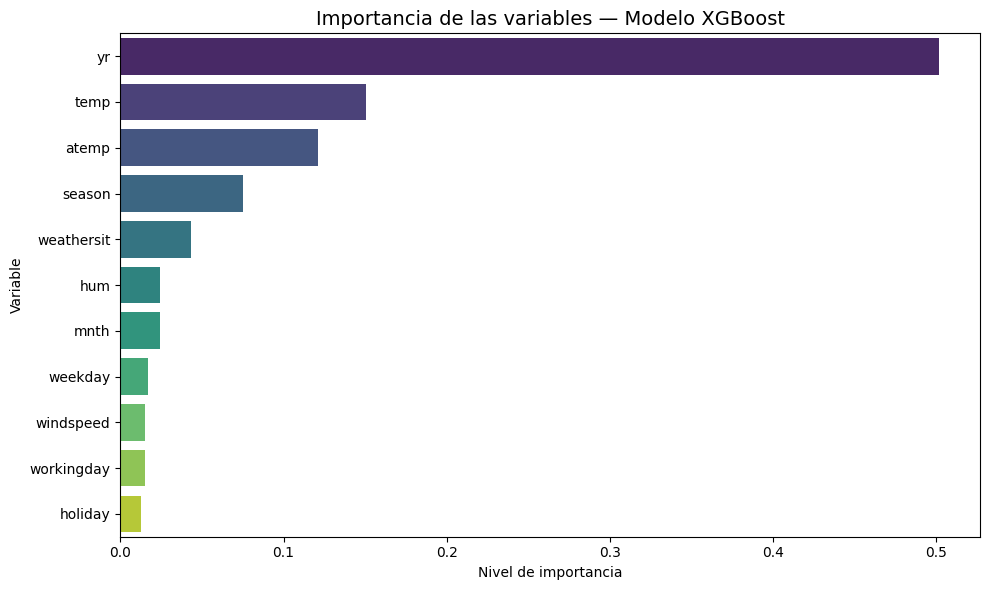

In [20]:
# Ejercicio 9a:

# ************* Inicia sección para agregar tu código:**************************
importancias = best_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Variable': X_train.columns,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

print("Importancia de las variables en el modelo XGBoost:\n")
display(feature_importance_df)

# 4️⃣ Gráfico de barras horizontal
plt.figure(figsize=(10,6))
sns.barplot(
    data=feature_importance_df,
    x='Importancia', 
    y='Variable', 
    palette='viridis'
)
plt.title("Importancia de las variables — Modelo XGBoost", fontsize=14)
plt.xlabel("Nivel de importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

### **Ejercicio 9b:**

* **Usa la librería SHAP con el mejor modelo encontrado para obtener los factores que influyen más en la predicción de la cantidad de bicicletas rentadas por día.**

NOTA: Puedes revisar la documentación correspondiente para el uso e interpretación de los gráficos de SHAP:

https://github.com/shap/shap

https://shap-readthedocs-io.translate.goog/en/latest/example_notebooks/api_examples/plots/beeswarm.html?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=tc



C:\Users\martc\AppData\Local\Temp\ipykernel_12632\3480728323.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train, plot_type="dot", show=True)


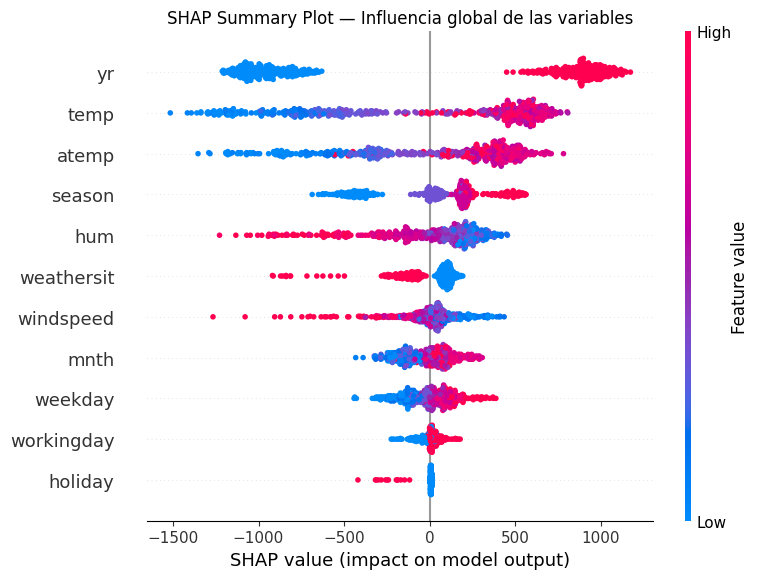

C:\Users\martc\AppData\Local\Temp\ipykernel_12632\3480728323.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train, plot_type="bar", show=True)


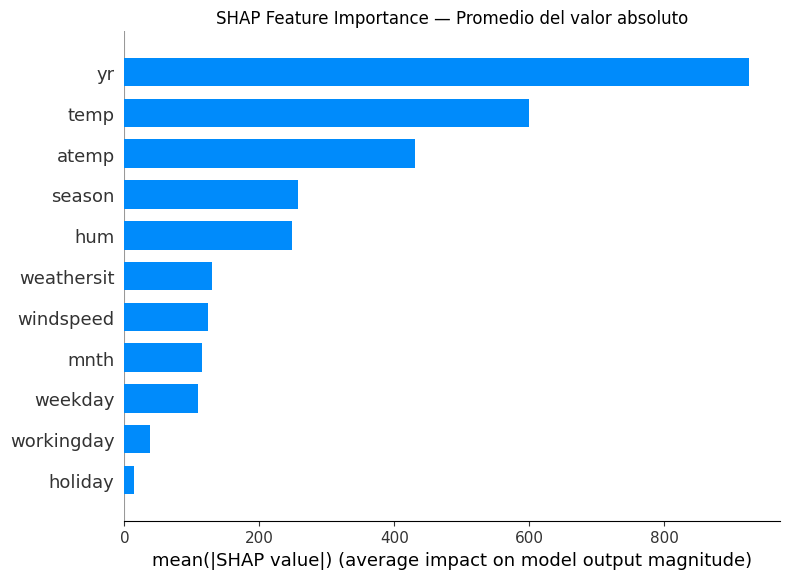


Ejemplo de interpretación individual para la observación 380:


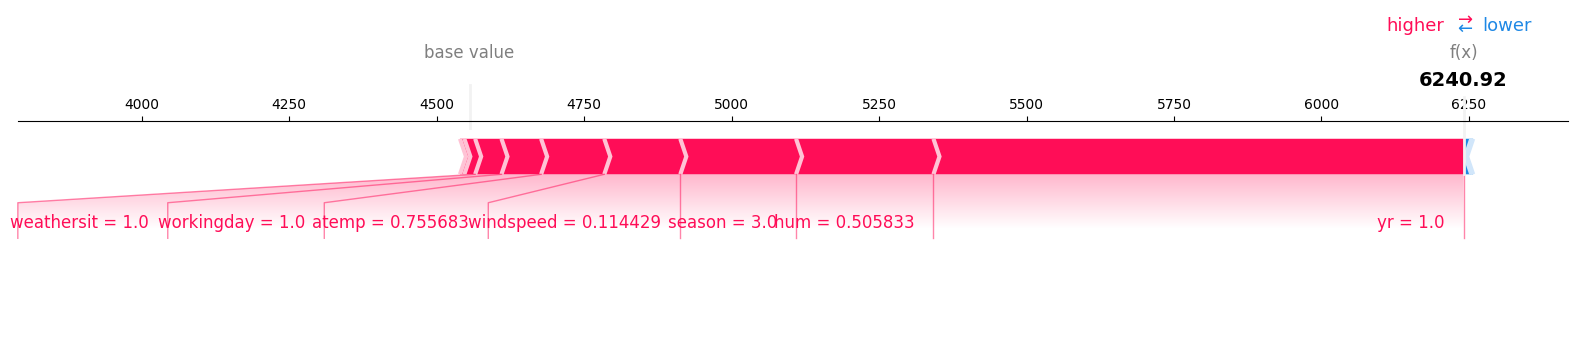

In [22]:
# Ejercicio 9b:

# ************* Inicia sección para agregar tu código:**************************
import shap

explainer = shap.TreeExplainer(best_model)

# Calcular los valores SHAP (influencia de cada variable sobre las predicciones)
shap_values = explainer.shap_values(X_train)

# Resumen general de las importancias (gráfico tipo beeswarm)
plt.title("SHAP Summary Plot — Influencia global de las variables")
shap.summary_plot(shap_values, X_train, plot_type="dot", show=True)

# Gráfico de barras promedio de importancia
plt.title("SHAP Feature Importance — Promedio del valor absoluto")
shap.summary_plot(shap_values, X_train, plot_type="bar", show=True)

# Ejemplo de explicación para una observación individual
# (Toma una muestra aleatoria de X_train)
idx = np.random.randint(0, X_train.shape[0])
print(f"\nEjemplo de interpretación individual para la observación {idx}:")
shap.force_plot(explainer.expected_value, shap_values[idx, :], X_train.iloc[idx, :], matplotlib=True)

### **Ejercicio 9c:**

* **Incluye tu interpretación de los resultados obtenidos. En particular indica las coincidencias y diferencias entre ambos métodos de importancia de factores.**

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Tanto el método tradicional de importancia de variables (feature_importances_) como el análisis con SHAP values coinciden en que las variables más influyentes en la predicción del número de bicicletas rentadas son:

yr (año)

temp (temperatura)

atemp (sensación térmica)

season (estación del año)

hum (humedad)

weathersit (tipo de clima)

Estas variables aparecen en las primeras posiciones en ambos métodos, lo que confirma la consistencia del modelo y la relevancia de los factores climáticos y temporales sobre la demanda.

**Coincidencias principales**

Ambas técnicas destacan la temperatura y la sensación térmica como los factores más determinantes: a mayor temperatura o confort térmico, mayor número de rentas.

El atributo yr también muestra una fuerte influencia, reflejando el crecimiento de usuarios entre 2011 y 2012.

season y weathersit capturan patrones estacionales y meteorológicos coherentes con la realidad (más rentas en verano y menos en invierno o días lluviosos).

**Diferencias observadas**

En el método feature_importances_ de XGBoost, la importancia se mide con base en la frecuencia de división (gain/split) en los árboles, por lo que no distingue entre efectos positivos o negativos.

En cambio, SHAP muestra además la dirección del impacto:

Valores SHAP positivos (en rojo) incrementan la predicción de cnt.

Valores SHAP negativos (en azul) reducen la predicción.

Por ejemplo, SHAP revela que valores altos de humedad o mal clima (weathersit elevado) disminuyen la demanda, algo que no se observa directamente con feature_importances_.

**Conclusión**

Ambos métodos son complementarios: la importancia de variables del modelo ofrece una visión global de relevancia, mientras que SHAP permite una interpretación detallada y direccional de cómo cada variable afecta las predicciones.
Esto refuerza la confianza en que el modelo XGBoost captura correctamente los patrones reales del fenómeno.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## **Ejercicio - 10**

Incluye tus conclusiones finales de la actividad.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

**Conclusiones generales:**

El modelo base (baseline) presentó un RMSE elevado (≈ 1016), al limitarse a predecir el promedio de la demanda.

El modelo XGBoost, optimizado mediante búsqueda en malla y validación cruzada, redujo el error a ≈ 602, logrando una mejora de más del 40% respecto al baseline.

Los parámetros óptimos (max_depth=5, learning_rate=0.05, n_estimators=200, subsample=0.8, colsample_bytree=0.8, min_child_weight=5) proporcionaron un equilibrio adecuado entre sesgo y varianza.

Los gráficos de importancia de variables y valores SHAP mostraron que factores como la temperatura, la sensación térmica, la estación y las condiciones climáticas son los determinantes principales de la demanda.

El modelo no solo logró un alto desempeño predictivo, sino también interpretabilidad, gracias al uso de herramientas como SHAP, que permiten comprender el efecto individual de cada variable.

**Reflexión final:**

El flujo completo —desde el modelo base hasta la explicación con SHAP— demuestra un proceso robusto de machine learning aplicado:

Preparación y análisis del conjunto de datos.

Construcción de un modelo base.

Optimización y validación cruzada del modelo XGBoost.

Interpretación y evaluación del impacto de cada variable.

Con esto, se logró desarrollar un modelo preciso, explicable y alineado con el comportamiento real del fenómeno de estudio, validando la efectividad del enfoque basado en XGBoost + interpretabilidad con SHAP.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# **Fin de la Actividad de modelos basados en árboles**